In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import hamming
import audio_functions as af
import plot


(0.0, 3.0)

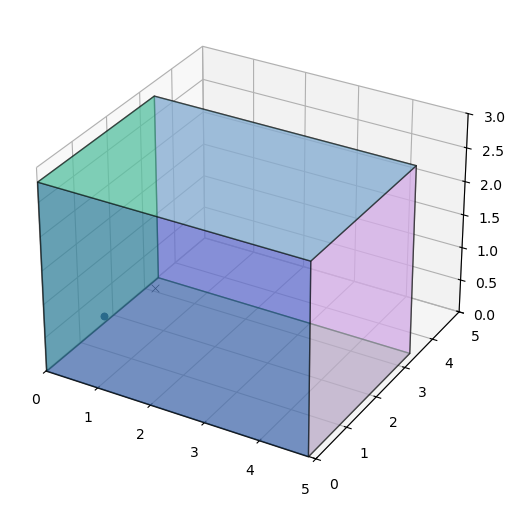

In [4]:
room_dim = [4.86, 3.43, 2.80]
fs = 48000
concrete = pra.Material('rough_concrete')
wood = pra.Material('wood_1.6cm')
ceramic = pra.Material('ceramic_tiles')
materials = {'east':concrete, 'west':concrete, 'north':concrete, 'south':concrete, 'ceiling':wood, 'floor':ceramic}
type(materials)
room = pra.ShoeBox(room_dim, fs=fs, max_order=10, materials=materials)
room.add_source([0.85, 0.47, 0.85])
room.add_microphone([1.5, 1.0, 1.2])

fig, ax = room.plot(mic_marker_size=30, source_marker_size=30)
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,3])

The RT60 is 104 ms


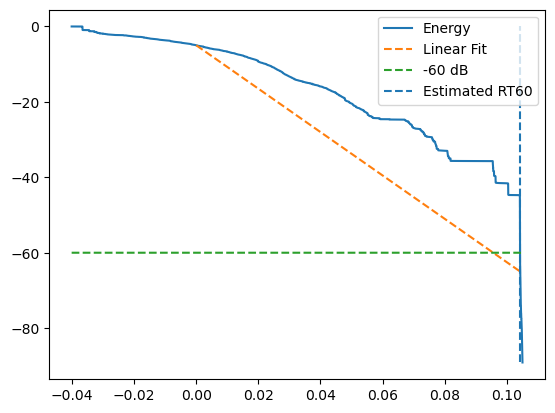

<Figure size 640x480 with 0 Axes>

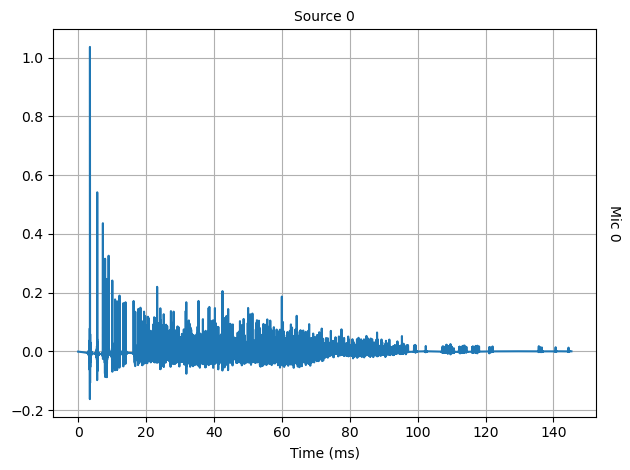

In [5]:
room.image_source_model()

room.compute_rir()

t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

plt.figure()
room.plot_rir()
plt.grid()

Num Frequency Bins 213
Standard Deviation 5.964063645365303
Min -28.08763797320314
Max 11.677610614353075
Delta 39.765248587556215


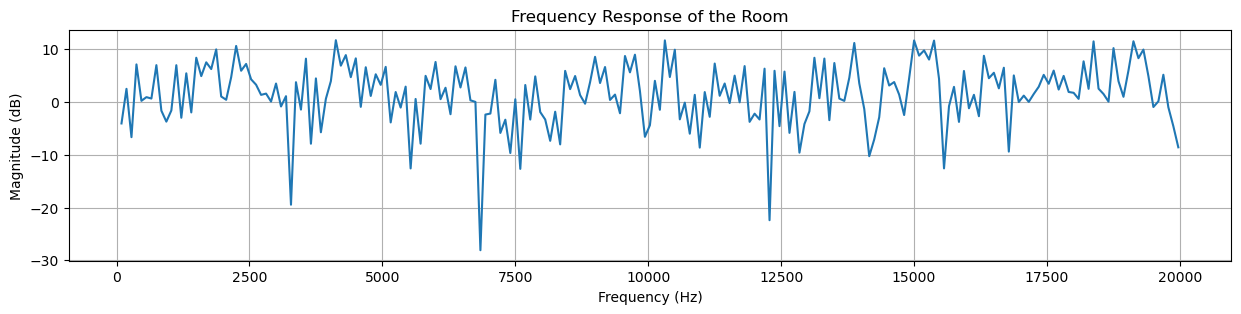

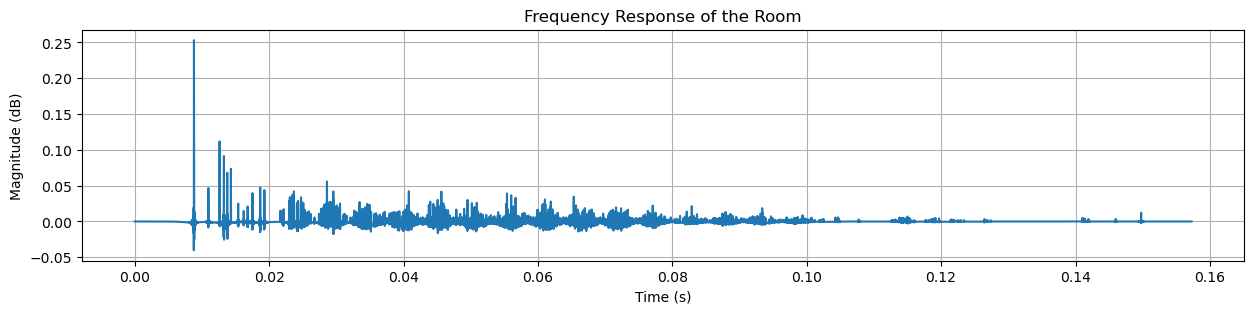

In [6]:
# Define the chunk size.
chunk_size = 512
step_size = chunk_size // 2
min_freq = 20
max_freq = 20000

# Pad the impulse resonse so that our chunks start before and after the impulse response.
rir = room.rir[0][0]
rir = np.pad(rir, (step_size, len(rir) % chunk_size))
t = np.arange(len(rir))/fs


# Initialize an array to store the averaged frequency response
avg_freq_response = np.zeros(chunk_size, dtype=np.complex128)

# Apply Hamming window to each chunk, compute FFT, and average
for i, start_idx in enumerate(range(0, len(rir) - chunk_size, step_size)):
    end_idx = start_idx + chunk_size
    chunk = rir[start_idx:end_idx]

    # Apply Hamming window
    chunk *= hamming(chunk_size)

    # Compute FFT
    freq_response_chunk = np.fft.fft(chunk)
    avg_freq_response += freq_response_chunk

# Get frequency axis for our valid
freq_axis = np.fft.fftfreq(len(avg_freq_response), d=1/room.fs)

# Crop valid audible frequencies, so our statistics don't include inaudible frequencies
valid_freqs = np.logical_and(min_freq < freq_axis, freq_axis < max_freq)
freq_axis = freq_axis[valid_freqs]
freq_response = avg_freq_response[valid_freqs]
print('Num Frequency Bins', len(freq_axis))


# Convert to decibels
freq_response = 20 * np.log10(np.abs(freq_response))

print('Standard Deviation', freq_response.std())
print('Min', freq_response.min())
print('Max', freq_response.max())
print('Delta', freq_response.max() - freq_response.min())


# Plot the frequency response
plt.figure(figsize=(15,3))
plt.plot(freq_axis, freq_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of the Room')
plt.grid(True)

plt.figure(figsize=(15,3))
plt.plot(t, rir)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of the Room')
plt.grid(True)

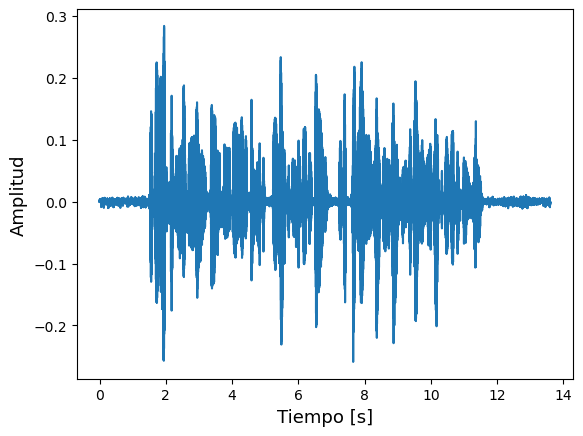

In [19]:
audio, fs = af.load_audio("audios_anecoicos/p336_023.wav")
t_2 = np.arange(len(audio))/fs
signal = {"time vector":t_2, "signal":audio, "label":"Audio Anecoico"}

plot.plot_signal(signal)
af.play_audio(audio, fs)

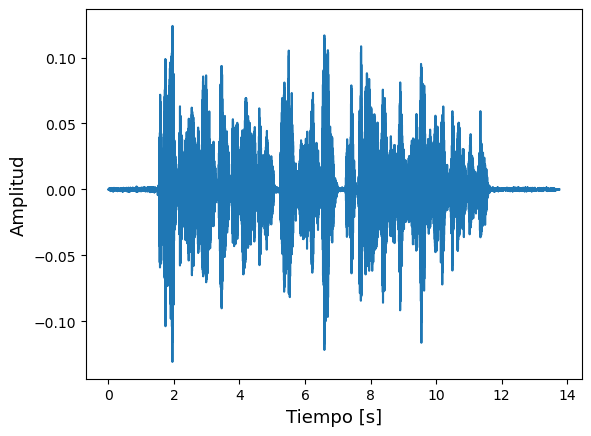

In [20]:
audio_auralized = af.reverb(rir, audio, fs, fs)
t_auralized = af.generate_time_vector(len(audio_auralized)/fs, fs)
signal_auralized = {"signal":audio_auralized, "time vector":t_auralized, "label":"Audio Auralizado"}

plot.plot_signal(signal_auralized)
af.play_audio(audio_auralized, fs)